In [3]:
import sys

sys.path.append('C:\\Users\\erik_\\Documents\\erik documents\\Programas\\PlasmaSimulations\\src')
# sys.path.append('...\\PlasmaSimulations\\src') # Replace dots with personal directory

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time

from scipy.stats import norm, uniform

import PIC_Solver

In [4]:
######  Define the parameters  #######

## Positions
k_param = 0.2 # wave number
L_x = 2*np.pi/k_param # Distance in positions direction
N_x = 128 # Number of slots in the x direction
print('L_x: ',L_x)

## Velocities
L_v = 10 # Distance in velocities direction
v_min = -L_v # Min velocity
v_max = L_v # Max velocity
N_v = 256 # Number of slots in the v direction 

## Time
T_max = 50 # Max integration time
M = 500 # Number of iterations

## Particle information
N_k = int(5e4) # Number of markers (particles)
q = -1 # Electron charge (adimensional)
mass = 1 # Electron mass (adimensional)

# Spline degree
spl_degree = 3

# Perturbation parameter for the bump on tail function
eps = 0.001

L_x:  31.41592653589793


In [5]:
#### Velocity distribution parameters for a binormal distribution

# Current 1
v_mean1 = 3.0 # Mean velocity of current 1
v_std1 = 1.0 # Standard deviation of current 1
weight_nb = 0.5 # weight of first current or fraction of particles in this sampling

# Current 2
v_mean2 = -3.0 # mean velocity of current 2
v_std2 = 1.0 # standard deviation of current 2

# Parameters of the velocity sampling distribution, in this case a binormal distribution
v_params = [v_mean1, v_std1, weight_nb, v_mean2, v_std2]

###########################################################################################################

#### Positions distribution parameters for a uniform distribution

length = L_x
initial_point = 0.0

# Vector of parameters of the positions sampling distribution, in this case a uniform distribution
x_params = [initial_point, length]

In [6]:
def sampling_dist(x,v):
    ''' The product of both PDFs (positions and velocities)'''
    # PDF of uniform distribution of particle positions
    dist1 = 1.0/L_x 
    # PDF of binormal distribution of particle velocities
    dist2 = weight_nb*1/(np.sqrt(2 * np.pi * v_std1**2)) * np.exp(-(v - v_mean1)**2/(2*v_std1**2)) + \
            (1-weight_nb)*1/(np.sqrt(2 * np.pi * v_std2**2)) * np.exp(-(v - v_mean2)**2/(2*v_std2**2)) 
    return dist1*dist2

In [7]:
def control_variate(v):
    '''Variable control function'''
    # PDF of binormal distribution of particle velocities
    return weight_nb*1/(np.sqrt(2 * np.pi * v_std1**2)) * np.exp(-(v - v_mean1)**2/(2*v_std1**2)) + \
            (1-weight_nb)*1/(np.sqrt(2 * np.pi * v_std2**2)) * np.exp(-(v - v_mean2)**2/(2*v_std2**2))

In [8]:
obj = PIC_Solver.PIC(N_k, q, mass, 0.0, L_x, N_x, 'uniform', x_params,v_min, v_max, N_v, 'binormal', v_params, T_max,
                     M, sampling_dist, control_variate, spl_degree, 'PIC_2Stream')

In [9]:
dx = obj.dx # position step
print('dx: ',dx)

dv = obj.dv # velocity step
print('dv: ',dv)

dt = obj.dt # time step
print('dt: ',dt)

dx:  0.2454369260617026
dv:  0.078125
dt:  0.1


In [10]:
# Initial Condition for a 2 stream instability
def two_current_initial_cond(x,v):
    return (weight_nb*1/(np.sqrt(2*np.pi*v_std1**2)) * np.exp(-(v - v_mean1)**2/(2*v_std1**2)) + \
    (1-weight_nb)*1/(np.sqrt(2 * np.pi * v_std2**2)) * np.exp(-(v - v_mean2)**2/(2*v_std2**2))) * \
    (1 + eps*np.cos(k_param*x))

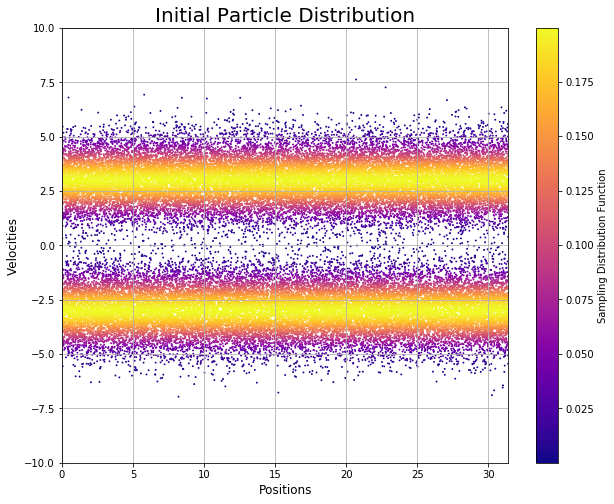

In [11]:
fig,ax = plt.subplots(figsize = (10,8))
ax.set_xlabel('Positions',fontsize = 'large')
ax.set_ylabel('Velocities',fontsize = 'large')
s = ax.scatter(obj.positions_sampling,obj.velocities_sampling ,s=0.8,
               c = two_current_initial_cond(obj.positions_sampling,obj.velocities_sampling),cmap='plasma')
plt. title('Initial Particle Distribution',fontsize = 20)
plt.grid()
fig.colorbar(s ,label = 'Sampling Distribution Function')
plt.xlim([0, L_x])
plt.ylim([-10, 10])
plt.show()

In [12]:
v_array = obj.grid_points(v_min,v_max,dv)

In [13]:
dist1 = norm.pdf(v_array, loc = v_mean1, scale = v_std1)
dist2 = norm.pdf(v_array, loc = v_mean2, scale = v_std2)

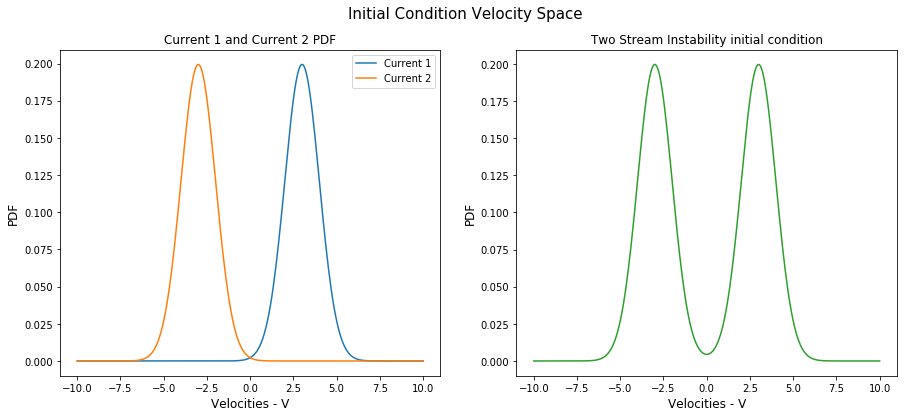

In [14]:
fig, ax = plt.subplots(1,2,figsize=(15,6))
fig.suptitle('Initial Condition Velocity Space',fontsize = 15) # general title

ax[0].plot(v_array, dist1*(weight_nb), label = 'Current 1')
ax[0].plot(v_array, dist2*(1-weight_nb), label = 'Current 2')
ax[0].set_title('Current 1 and Current 2 PDF')
ax[1].plot(v_array, two_current_initial_cond(1,v_array),c='tab:green')
ax[1].set_title('Two Stream Instability initial condition')

# Add x and y labels
for axx in ax.flat:
    axx.set_ylabel('PDF',fontsize = 12)
    axx.set_xlabel('Velocities - V',fontsize = 12)

ax[0].legend()
plt.show()

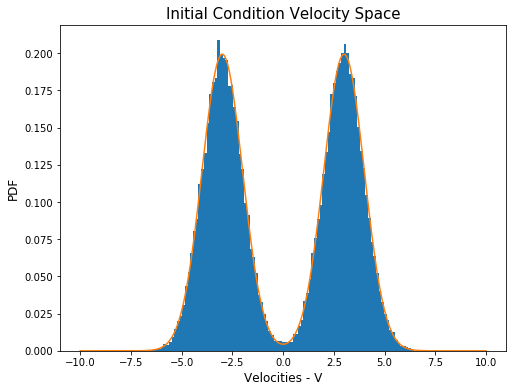

In [15]:
plt.figure(figsize=(8,6))
plt.title('Initial Condition Velocity Space',fontsize = 15) # general title
plt.hist(obj.velocities_sampling, bins = 110,density=True)
plt.plot(v_array,two_current_initial_cond(10,v_array))
plt.xlabel('Velocities - V',fontsize = 12)
plt.ylabel('PDF',fontsize = 12)
plt.show()

### Run Model

In [16]:
start_time = time.time()

obj.run_iteration()

end_time = time.time()
print('Total execution time: ',(end_time-start_time)/60.)

Total execution time:  33.74755353132884


### Open file

In [17]:
data_pic = np.loadtxt("PIC_2Stream.txt")
data_pic.shape

(1002, 50000)

In [18]:
data_pic = data_pic.reshape(M + 1, 2 , N_k)
data_pic.shape

(501, 2, 50000)

In [19]:
t_grid = obj.grid_points(0.0, T_max, dt)

In [23]:
init_pos = data_pic[0][0]
init_vel = data_pic[0][1]

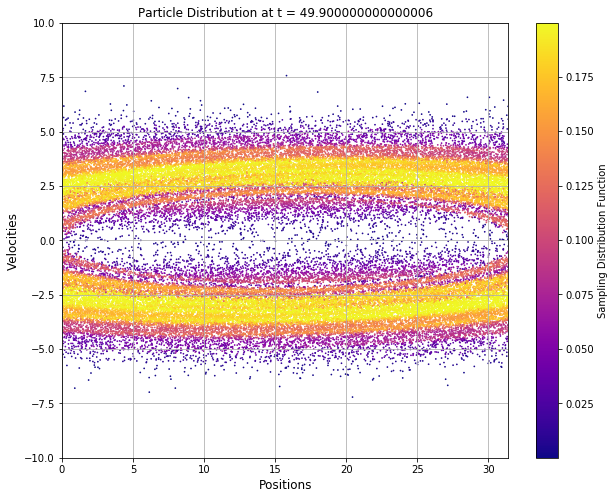

In [27]:
fig,ax = plt.subplots(figsize = (10,8))
ax.set_xlabel('Positions',fontsize = 'large')
ax.set_ylabel('Velocities',fontsize = 'large')
time_idx = 499
s = ax.scatter(data_pic[time_idx][0], data_pic[time_idx][1], s = 0.5,
              c = two_current_initial_cond(init_pos,init_vel),cmap='plasma')
plt. title(f'Particle Distribution at t = {t_grid[time_idx]}')
plt.grid()
fig.colorbar(s ,label = 'Sampling Distribution Function')
plt.xlim([0, L_x])
plt.ylim([-10, 10])
plt.show()

In [25]:
time_plot = [0, 100, 200, 300, 400, 500] #times to plot

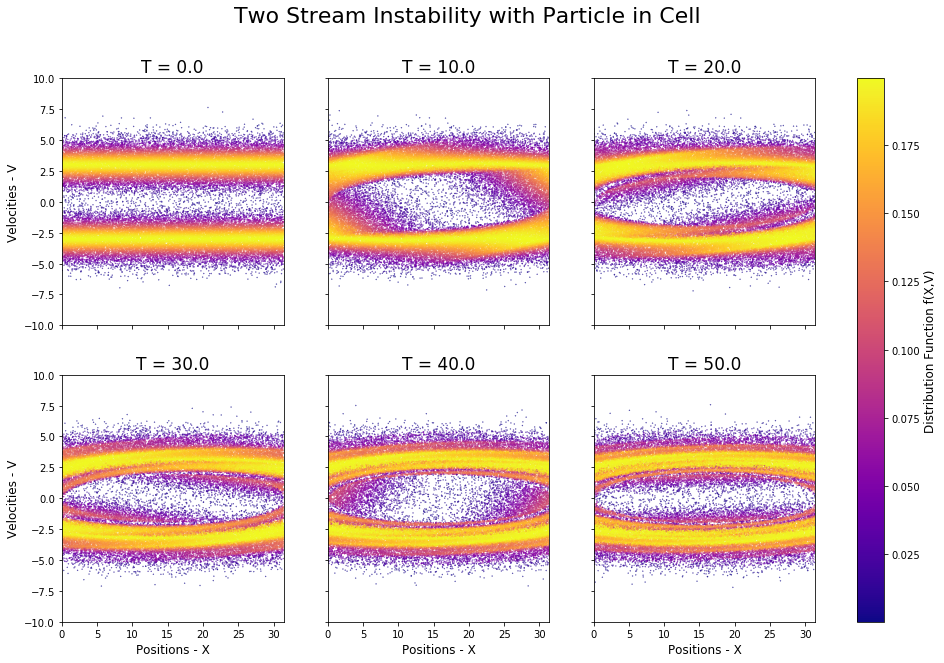

In [28]:
### Create plots of the distribution function at different times

fig, ax = plt.subplots(2, 3,figsize=(15,10))
fig.suptitle('Two Stream Instability with Particle in Cell',fontsize = 22) # general title

ti = 0 # index counter
images = [] # list to store images

for i in range(2): 
    for j in range(3):
        cp = ax[i,j].scatter(data_pic[time_plot[ti]][0], data_pic[time_plot[ti]][1], s = 0.1,
                            c = two_current_initial_cond(init_pos,init_vel),cmap='plasma')
        ax[i,j].set_title(f'T = {time_plot[ti]*dt}',fontsize = 17) # create title
        ax[i,j].set_xlim([0, L_x])
        ax[i,j].set_ylim([-L_v, L_v])
        images.append(cp) # save contour in list
        ti+=1 
        
# Add x and y labels
for axx in ax.flat:
    axx.set_xlabel('Positions - X',fontsize = 12)
    axx.set_ylabel('Velocities - V',fontsize = 12)

# Add a colorbar to a plot
cbar = fig.colorbar(images[0], ax=ax, orientation='vertical', fraction=.05)
cbar.ax.set_ylabel('Distribution Function f(X,V)',fontsize = 12)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for axx in ax.flat:
    axx.label_outer()